In [1]:
# Importar librerías de manipulación de datos
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas del DataFrame
pd.set_option('display.expand_frame_repr', False)  # Evitar que el DataFrame se divida en varias líneas si tiene muchas columnas

# Importar librerías para manejo de tiempo y fecha
import time
from datetime import datetime, timedelta, timezone

# Importar librerías de scraping
import requests
from bs4 import BeautifulSoup

# Importar librerías de visualización
import matplotlib.pyplot as plt
plt.rc('figure', figsize = (5, 5))  # Establecer el tamaño predeterminado de las figuras a 5x5 pulgadas

# Importar librerías específicas de entorno Jupyter
from IPython.display import clear_output

# Importar librería para obtención de datos financieros
import yfinance as yf

from IPython.display import display, HTML

# Variables globales
global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color

Obtención

In [2]:
def importar_base_bitcoin():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color

    end_date = datetime.now(timezone.utc)
    start_date = end_date - timedelta(days=7)

    df_bitcoin = yf.download("BTC-USD", start=start_date, end=end_date, interval= "5m")
    
    if df_bitcoin.empty:
        raise ValueError("No se obtuvieron datos de finance")
    
    df_bitcoin.columns = [col[0] for col in df_bitcoin.columns]

    return df_bitcoin

In [3]:
importar_base_bitcoin()
df_bitcoin.head()

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Datetime,,,,,
2025-01-21 04:25:00+00:00,102688.992188,102821.304688,102688.992188,102697.984375,0
2025-01-21 04:30:00+00:00,102272.078125,102579.953125,102272.078125,102579.953125,0
2025-01-21 04:35:00+00:00,102041.906250,102041.906250,101921.562500,101986.046875,25755648
2025-01-21 04:40:00+00:00,102150.906250,102237.812500,102080.140625,102080.140625,163995648
2025-01-21 04:45:00+00:00,102215.273438,102215.273438,102188.968750,102194.804688,13049856


In [4]:
print(df_bitcoin.info())
df_bitcoin.describe().round(0)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2009 entries, 2025-01-21 04:25:00+00:00 to 2025-01-28 04:20:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2009 non-null   float64
 1   High    2009 non-null   float64
 2   Low     2009 non-null   float64
 3   Open    2009 non-null   float64
 4   Volume  2009 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 94.2 KB
None


,Close,High,Low,Open,Volume
count,2009.0,2009.0,2009.0,2009.0,2.009000e+03
mean,103851.0,103911.0,103788.0,103850.0,7.457145e+07
std,1873.0,1863.0,1885.0,1875.0,1.763026e+08
min,98105.0,98261.0,97907.0,97907.0,0.000000e+00
25%,102538.0,102573.0,102432.0,102514.0,0.000000e+00
50%,104568.0,104613.0,104528.0,104576.0,0.000000e+00
75%,105053.0,105088.0,105009.0,105053.0,7.214285e+07
max,107128.0,107157.0,107024.0,107146.0,2.702049e+09


[*********************100%***********************]  1 of 1 completed


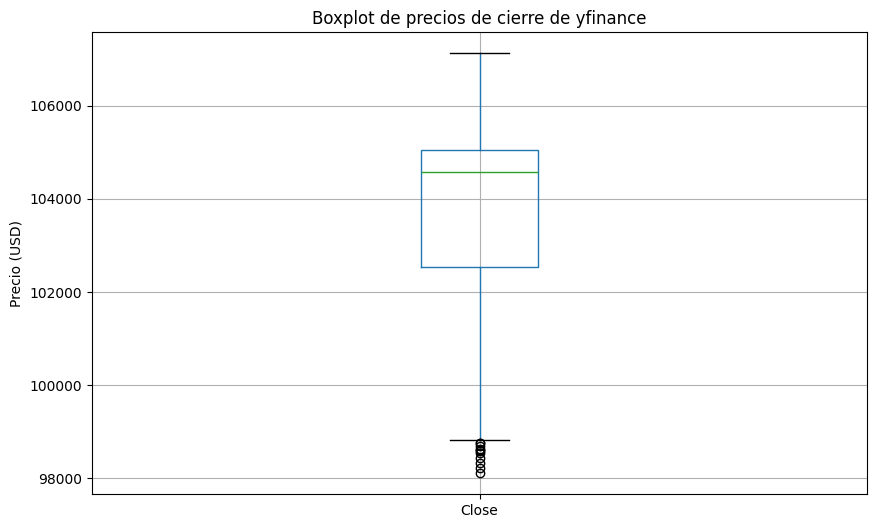

In [5]:
importar_base_bitcoin()

plt.figure(figsize=(10, 6))           
df_bitcoin.boxplot(column=['Close'])
plt.title('Boxplot de precios de cierre de yfinance')
plt.ylabel('Precio (USD)')
plt.show()

Limpieza 

In [6]:
def limpieza_datos():
    global df_bitcoin, df_bitcoin_limpio, media_bitcoin, precio_actual, tendencia

    num_datos_inicial = df_bitcoin.shape[0]
    print(f"Numero inicial de datos: {num_datos_inicial}")

    #copiar el df
    df_bitcoin_limpio = df_bitcoin.copy()

    #eliminar indices duplicados
    duplicado_inicial = df_bitcoin_limpio.index.duplicated(keep='first').sum()
    df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]
    duplicados_eliminados = duplicado_inicial 
    print(f"Duplicados elimindos: {duplicados_eliminados}")
    
    #rellenar valores nulos
    df_bitcoin_limpio['Close'] = df_bitcoin_limpio['Close'].ffill()

    # eliminar filas donde el volumen sea menor o igual a cero
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

    #Calcular los cuartiles identificar y eliminar valores atipicos
    Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
    Q3 = df_bitcoin_limpio['Close'].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 -1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    print(f"Limites de eliminacion de outliers: Inferior {limite_inferior}, Superior: {limite_superior}")

    df_bitcoin_limpio = df_bitcoin_limpio[
        (df_bitcoin_limpio['Close'] >= limite_inferior) &
        (df_bitcoin_limpio['Close'] <= limite_superior)      
        
        ]    
    num_final = len(df_bitcoin_limpio)
    datos_elimindos = num_datos_inicial - num_final
    print(f"Numero final de dtos: {num_final}")
    print (f"Datos eliminados durnte la limpieza: {datos_elimindos}")

    #precio promedio
    media_bitcoin = df_bitcoin_limpio['Close'].mean()

    return df_bitcoin_limpio, media_bitcoin    

Numero inicial de datos: 2009
Duplicados elimindos: 0
Limites de eliminacion de outliers: Inferior 96306.4951171875, Superior: 109643.0810546875
Numero final de dtos: 800
Datos eliminados durnte la limpiez: 1209


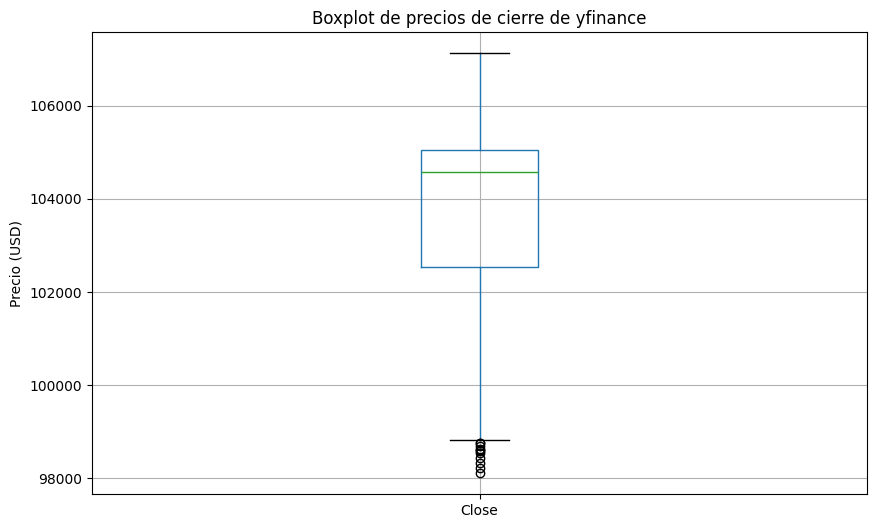

In [7]:
limpieza_datos()

plt.figure(figsize=(10, 6))           
df_bitcoin.boxplot(column=['Close'])
plt.title('Boxplot de precios de cierre de yfinance')
plt.ylabel('Precio (USD)')
plt.show()

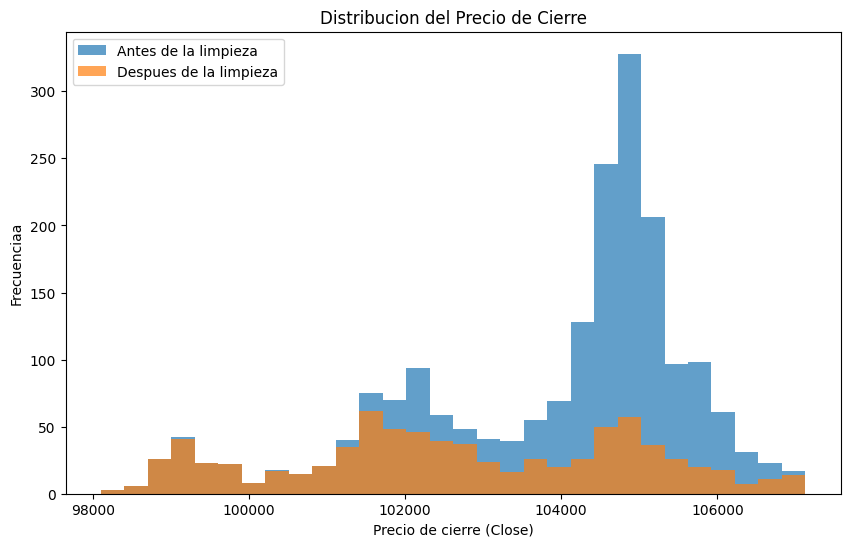

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(df_bitcoin['Close'], bins=30, alpha=0.7, label='Antes de la limpieza')
plt.hist(df_bitcoin_limpio['Close'], bins=30, alpha=0.7, label='Despues de la limpieza')
plt.legend()
plt.title('Distribucion del Precio de Cierre')
plt.xlabel('Precio de cierre (Close)')
plt.ylabel('Frecuenciaa')
plt.show()



Extracción de Tendencias

In [9]:
def extraer_tendencias():
    global precio_actual, tendencia, color
    global df_bitcoin, df_bitcoin_limpio, media_bitcoin, algoritmo_decision

    # Calcular la media móvil de 20 periodos (20 dias habiles en un mes de trading)
    media_bitcoin = df_bitcoin_limpio['Close'].rolling(window=20).mean() # 20 es el anlisis financiero estandar en la practica, 

    # Obtener el precio actual (último valor en el dataframe limpio)
    precio_actual = df_bitcoin_limpio['Close'].iloc[-1]
    
    # Determinar la tendencia
    if precio_actual > media_bitcoin.iloc[-1]:
        tendencia = "alcista"
        color = "#228B22"
    else:
        tendencia = "bajista"
        color = "#dc143c"

    # Imprimir la tendencia
    print(f"Tendencia actual: {tendencia}, Precio actual: {precio_actual}")
    
    # Algoritmo de decisión
    if tendencia == "alcista":
        algoritmo_decision = "Comprar"
    elif tendencia == "bajista":
        algoritmo_decision = "Vender"

    display(HTML(f"""
    <div style='display: inline-flex; align-items: center; gap: 10px; font-size: 15px; font-family: monospace;'>
        <span>Decisión del algoritmo: {algoritmo_decision} </span>
        <div style='width: 20px; height: 20px; border-radius: 50%; background-color: {color};'></div>
    </div>
    """))

Tendencia actual: alcista, Precio actual: 102729.25


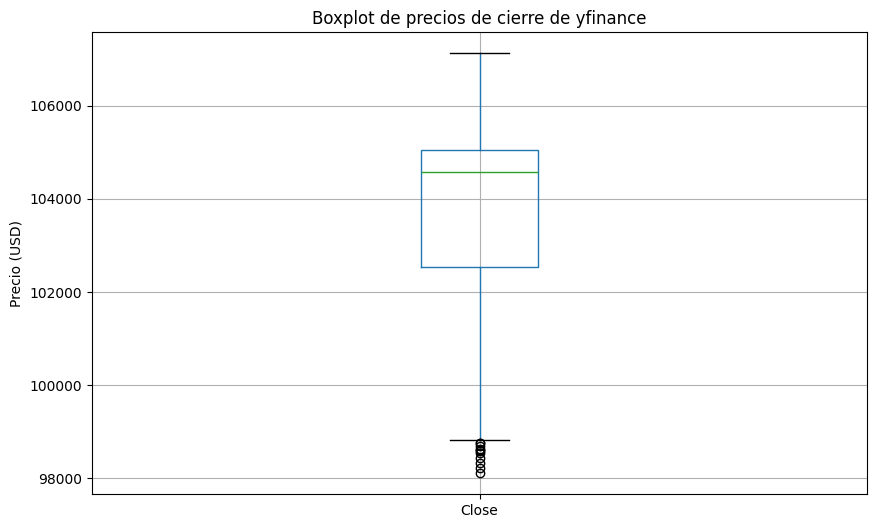

In [10]:
extraer_tendencias()

plt.figure(figsize=(10, 6))           
df_bitcoin.boxplot(column=['Close'])
plt.title('Boxplot de precios de cierre de yfinance')
plt.ylabel('Precio (USD)')
plt.show()

In [11]:
def calcular_sma():
    global df_bitcoin_limpio

    #calcular SMA de corto plazo 
    df_bitcoin_limpio['SMA_corto'] = df_bitcoin_limpio['Close'].rolling(window=10).mean()

    #calcular SMA largo
    df_bitcoin_limpio['SMA_largo'] = df_bitcoin_limpio['Close'].rolling(window=50).mean()

    return df_bitcoin_limpio

In [12]:
calcular_sma()

,Close,High,Low,Open,Volume,SMA_corto,SMA_largo
Datetime,,,,,,,
2025-01-21 04:35:00+00:00,102041.906250,102041.906250,101921.562500,101986.046875,25755648,NaN,NaN
2025-01-21 04:40:00+00:00,102150.906250,102237.812500,102080.140625,102080.140625,163995648,NaN,NaN
2025-01-21 04:45:00+00:00,102215.273438,102215.273438,102188.968750,102194.804688,13049856,NaN,NaN
2025-01-21 05:20:00+00:00,101812.203125,101937.781250,101783.312500,101937.781250,4456448,NaN,NaN
2025-01-21 05:30:00+00:00,101480.750000,101840.523438,101480.750000,101840.523438,5971968,NaN,NaN
...,...,...,...,...,...,...,...
2025-01-28 03:50:00+00:00,102736.601562,102747.750000,102736.601562,102747.750000,143638528,102315.048437,101775.342656
2025-01-28 03:55:00+00:00,102624.164062,102786.523438,102622.117188,102786.523438,46653440,102394.575000,101814.315156
2025-01-28 04:00:00+00:00,102612.437500,102714.101562,102612.437500,102623.421875,160743424,102466.685938,101849.497656


Toma de decisión

In [13]:
def tomar_decisiones():
    global df_bitcoin_limpio, tendencia, media_bitcoin, precio_actual

    # Calcular la media móvil de 20 periodos
    media_bitcoin = df_bitcoin_limpio['Close'].rolling(window=20).mean()

    # Obtener el precio actual (último valor en el dataframe limpio)
    precio_actual = df_bitcoin_limpio['Close'].iloc[-1]

    # Determinar la tendencia
    if precio_actual > media_bitcoin.iloc[-1]:
        tendencia = "alcista"  # Precio por encima de la media = tendencia alcista
    else:
        tendencia = "bajista"  # Precio por debajo de la media = tendencia bajista

    # Calcular las SMAs
    sma_corto_actual = df_bitcoin_limpio['SMA_corto'].iloc[-1]
    sma_largo_actual = df_bitcoin_limpio['SMA_largo'].iloc[-1]

    # Lógica de decisión (Comprar, Vender o Mantener)
    if sma_corto_actual > sma_largo_actual and tendencia == 'alcista':
        algoritmo_decision = 'Comprar'
        color = '#228b22'  # Verde
    elif sma_corto_actual < sma_largo_actual and tendencia == 'bajista':
        algoritmo_decision = 'Vender'
        color = '#dc143c'  # Rojo
    else:
        algoritmo_decision = 'Mantener'
        color = '#000000'  # Negro

    # Guardar la decisión en el dataframe
    df_bitcoin_limpio.loc[df_bitcoin_limpio.index[-1], 'Decision'] = algoritmo_decision

    # Imprimir la decisión
    print(f"Decisión: {algoritmo_decision} | SMA corto: {sma_corto_actual} | SMA largo: {sma_largo_actual}")
    print(f"Tendencia: {tendencia} | Precio actual: {precio_actual}")

    return df_bitcoin_limpio, algoritmo_decision, color

        

In [14]:
tomar_decisiones()

print(algoritmo_decision)


Decisión: Comprar | SMA corto: 102602.4578125 | SMA largo: 101907.2565625
Tendencia: alcista | Precio actual: 102729.25
Comprar


In [15]:


def graficar_senal_actual():
    global algoritmo_decision, color
    global df_bitcoin, df_bitcoin_limpio

    # Graficar el precio de Bitcoin y las medias móviles
    plt.figure(figsize=(15, 10))

    # Graficar el precio de cierre
    plt.plot(df_bitcoin_limpio['Close'], label='Precio de Cierre', color='gray', alpha=0.7)

    # Graficar la SMA corta y larga
    plt.plot(df_bitcoin_limpio['SMA_corto'], label='SMA 10 días', color='blue', linestyle='--', alpha=0.7)
    plt.plot(df_bitcoin_limpio['SMA_largo'], label='SMA 50 días', color='orange', linestyle='--', alpha=0.7)

    # Añadir la señal actual con un marcador
    ultimo_precio = df_bitcoin_limpio['Close'].iloc[-1]
    plt.scatter(df_bitcoin_limpio.index[-1], ultimo_precio,
                color=color, marker='v', s=200, label='Señal Actual')
    
    # Personalización de la gráfica
    plt.title('Señal de Compra/Venta')
    plt.xlabel('Tiempo')
    plt.ylabel('Precio')
    plt.legend()  
    plt.grid(True, alpha=0.3)

    #  texto con la decisión actual
    plt.text(0.02, 0.98, f'Decisión Actual: {algoritmo_decision}', 
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='purple', alpha=0.5),
             verticalalignment='top')
        
    # Mostrar la gráfica
    plt.tight_layout()
    plt.show()


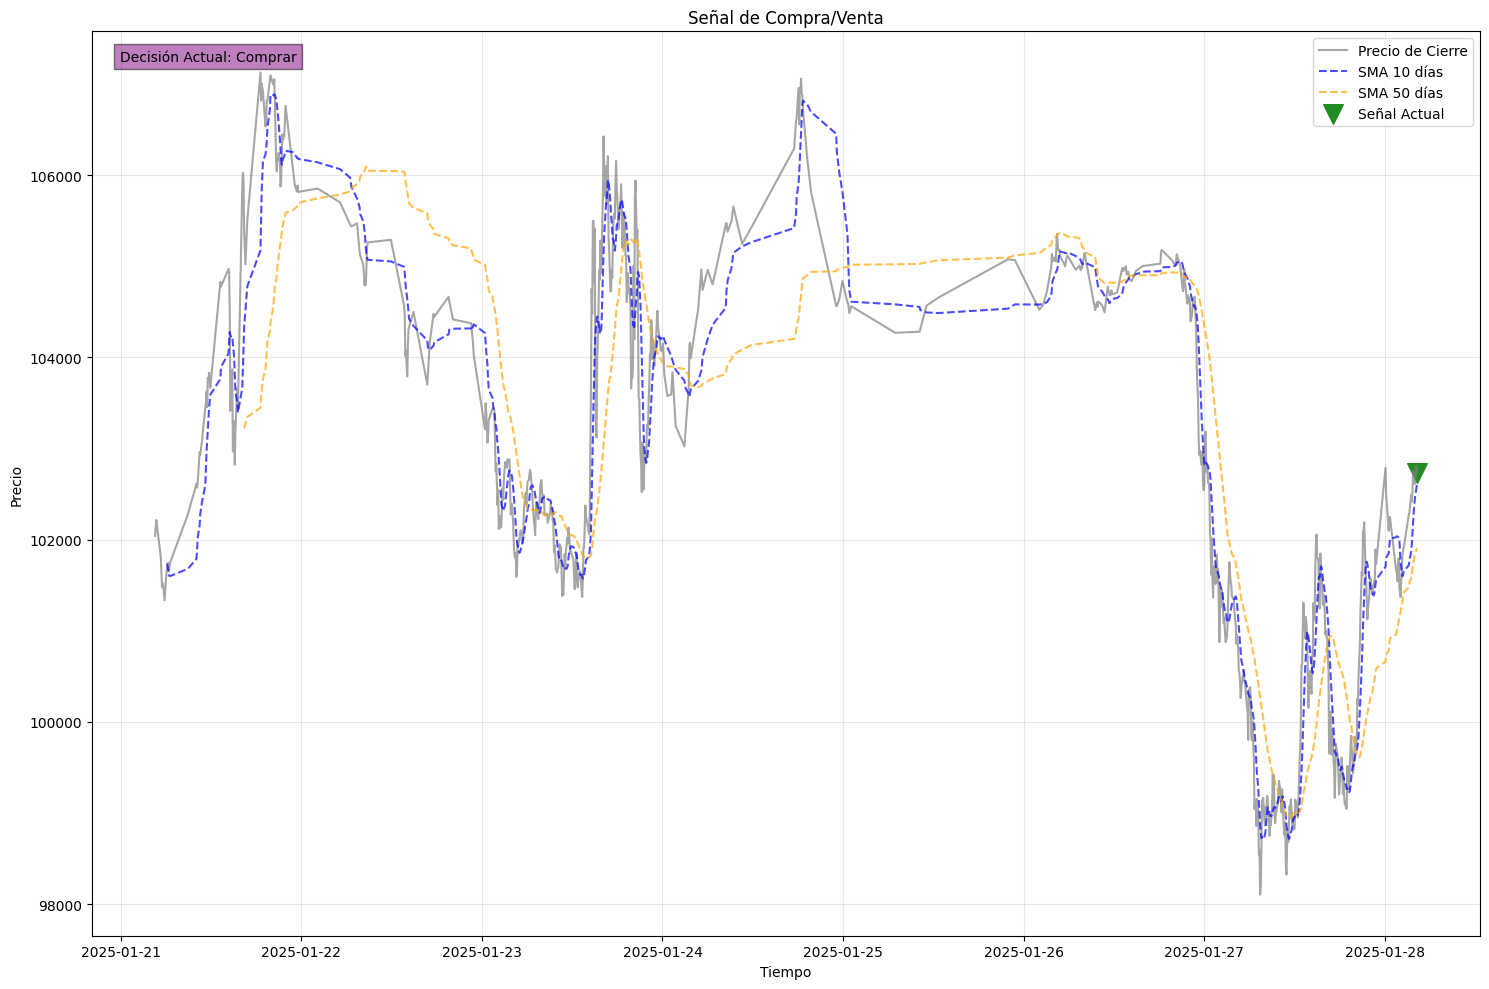

In [16]:
graficar_senal_actual()

Iniciando ciclo de análisis...


[*********************100%***********************]  1 of 1 completed

Tendencia actual: alcista, Precio actual: 102729.25


Numero inicial de datos: 2009
Duplicados elimindos: 0
Limites de eliminacion de outliers: Inferior 96306.4951171875, Superior: 109643.0810546875
Numero final de dtos: 800
Datos eliminados durnte la limpiez: 1209
Decisión: Comprar | SMA corto: 102602.4578125 | SMA largo: 101907.2565625
Tendencia: alcista | Precio actual: 102729.25


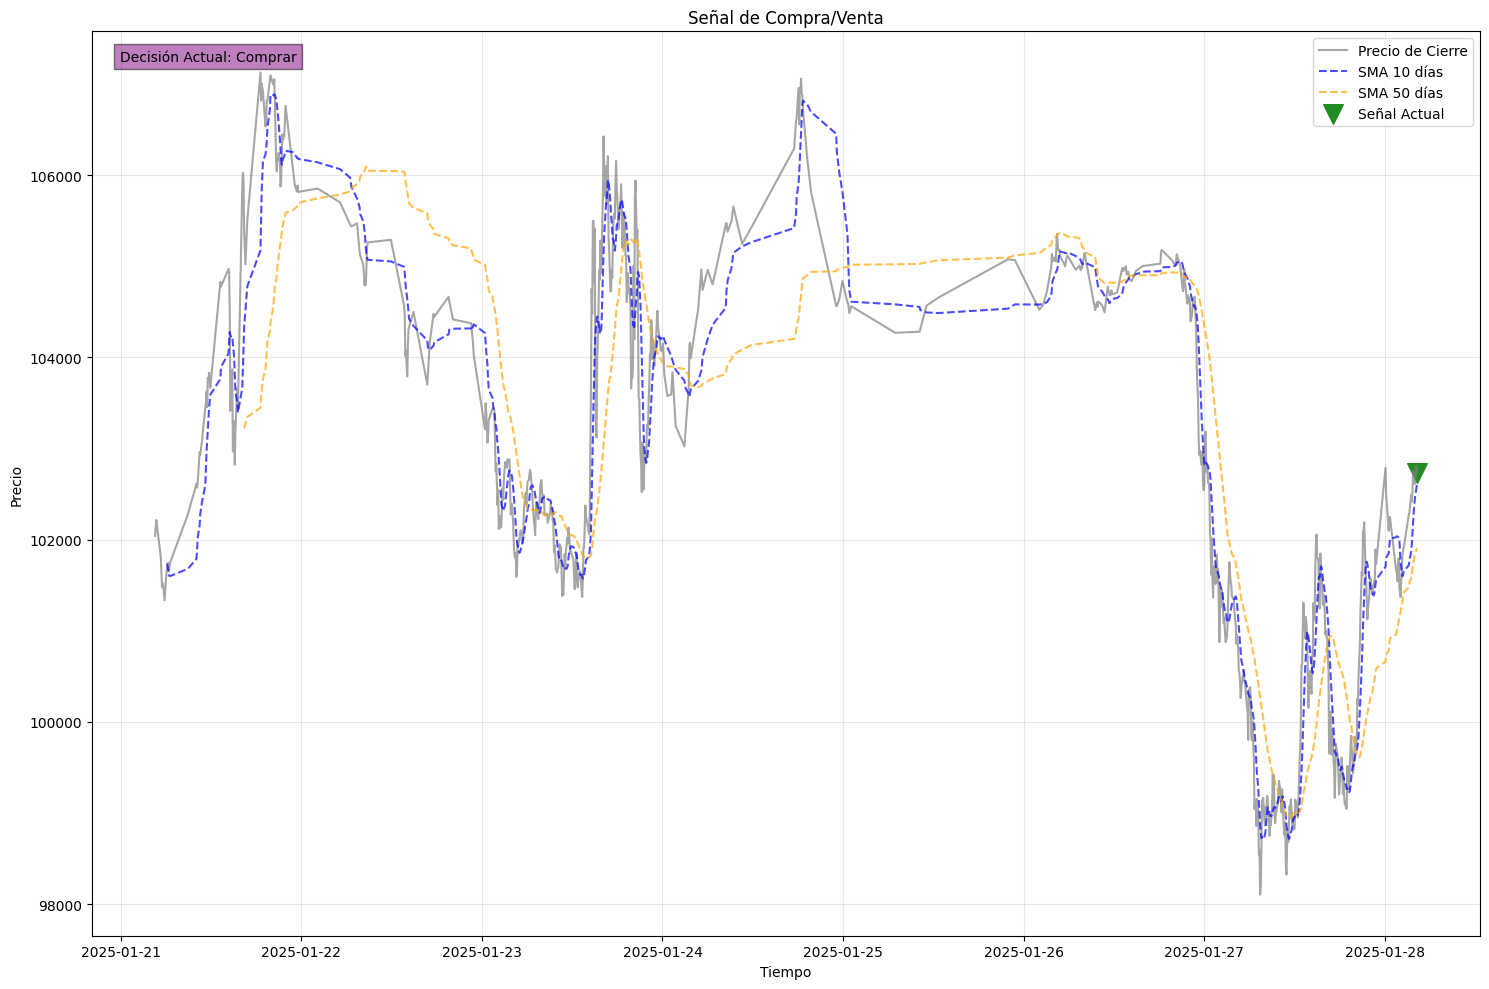

Esperando 5 minutos antes de la siguiente decisión...
Iniciando ciclo de análisis...


[*********************100%***********************]  1 of 1 completed

Tendencia actual: alcista, Precio actual: 102729.25


Numero inicial de datos: 2010
Duplicados elimindos: 0
Limites de eliminacion de outliers: Inferior 96311.91796875, Superior: 109636.07421875
Numero final de dtos: 801
Datos eliminados durnte la limpiez: 1209
Decisión: Comprar | SMA corto: 102668.1671875 | SMA largo: 101933.42515625
Tendencia: alcista | Precio actual: 102955.3046875


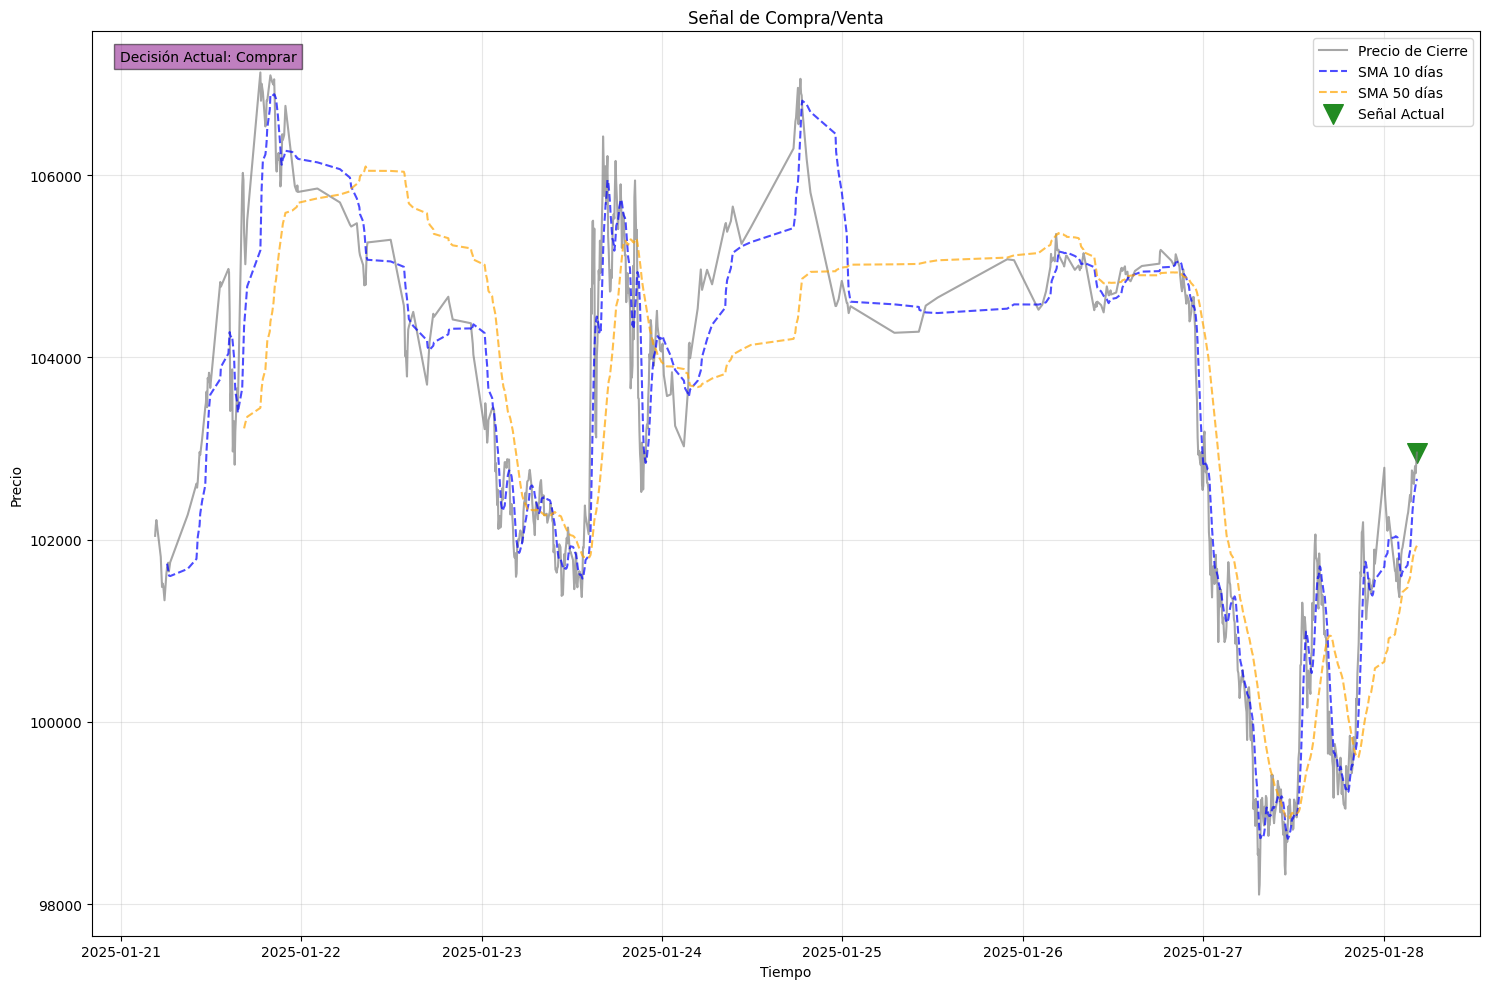

Esperando 5 minutos antes de la siguiente decisión...
Iniciando ciclo de análisis...


[*********************100%***********************]  1 of 1 completed

Tendencia actual: alcista, Precio actual: 102955.3046875


Numero inicial de datos: 2016
Duplicados elimindos: 0
Limites de eliminacion de outliers: Inferior 96265.94921875, Superior: 109694.60546875
Numero final de dtos: 795
Datos eliminados durnte la limpiez: 1221
Decisión: Comprar | SMA corto: 102730.925 | SMA largo: 101823.2665625
Tendencia: alcista | Precio actual: 103118.8359375


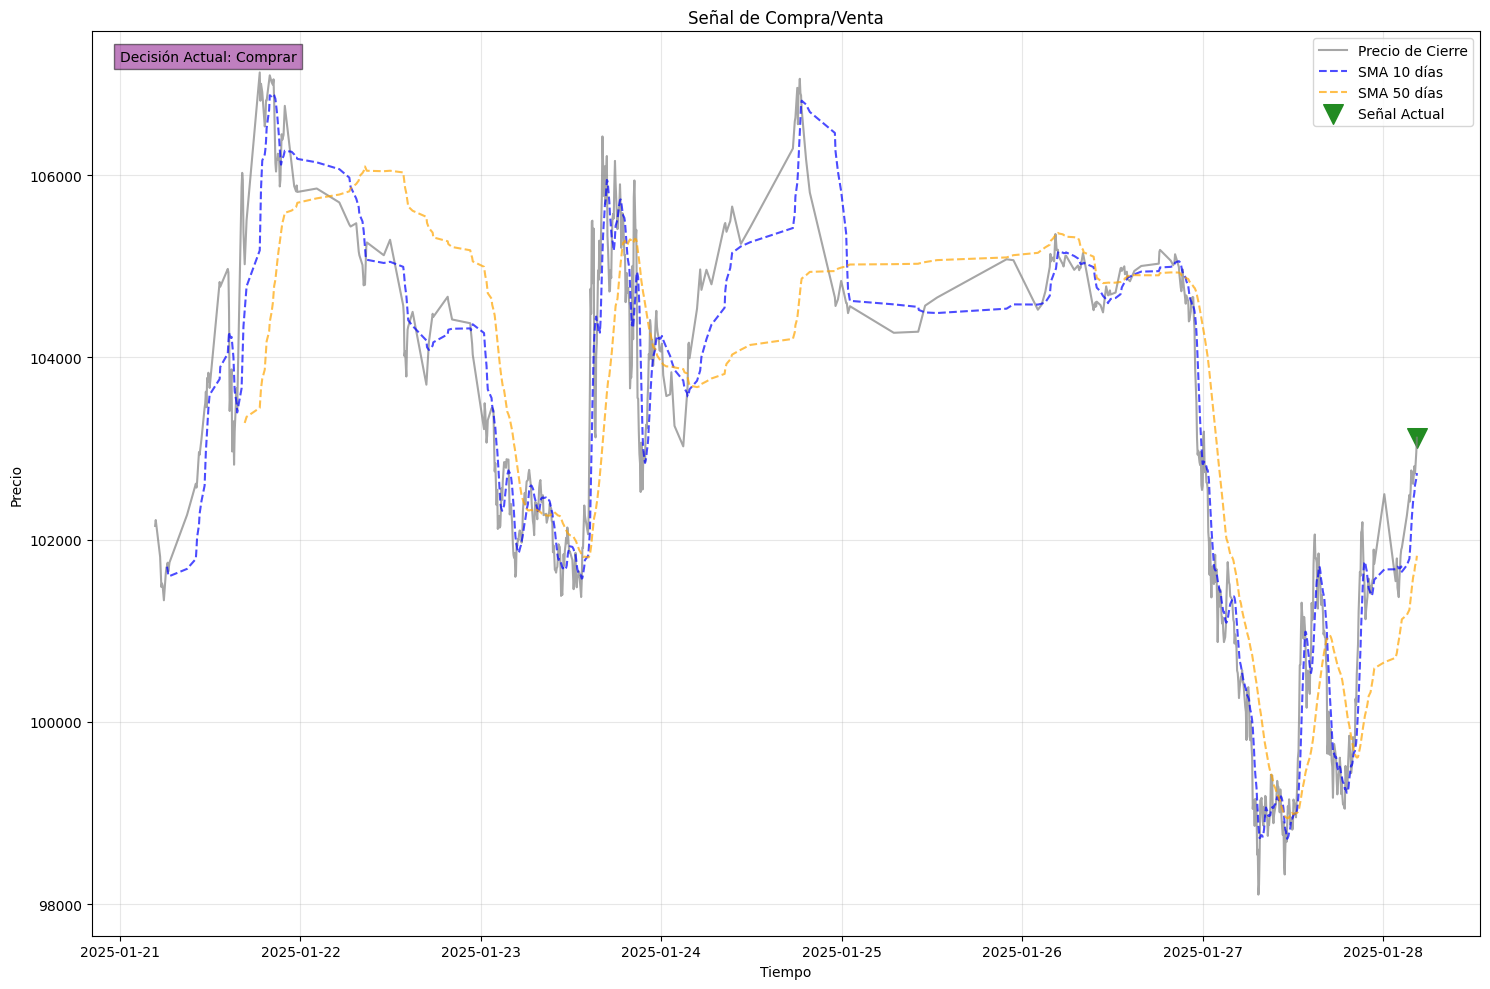

Esperando 5 minutos antes de la siguiente decisión...
Iniciando ciclo de análisis...


[*********************100%***********************]  1 of 1 completed

Tendencia actual: alcista, Precio actual: 103118.8359375


Numero inicial de datos: 2016
Duplicados elimindos: 0
Limites de eliminacion de outliers: Inferior 96265.94921875, Superior: 109694.60546875
Numero final de dtos: 795
Datos eliminados durnte la limpiez: 1221
Decisión: Comprar | SMA corto: 102822.50234375 | SMA largo: 101879.4984375
Tendencia: alcista | Precio actual: 103334.4921875


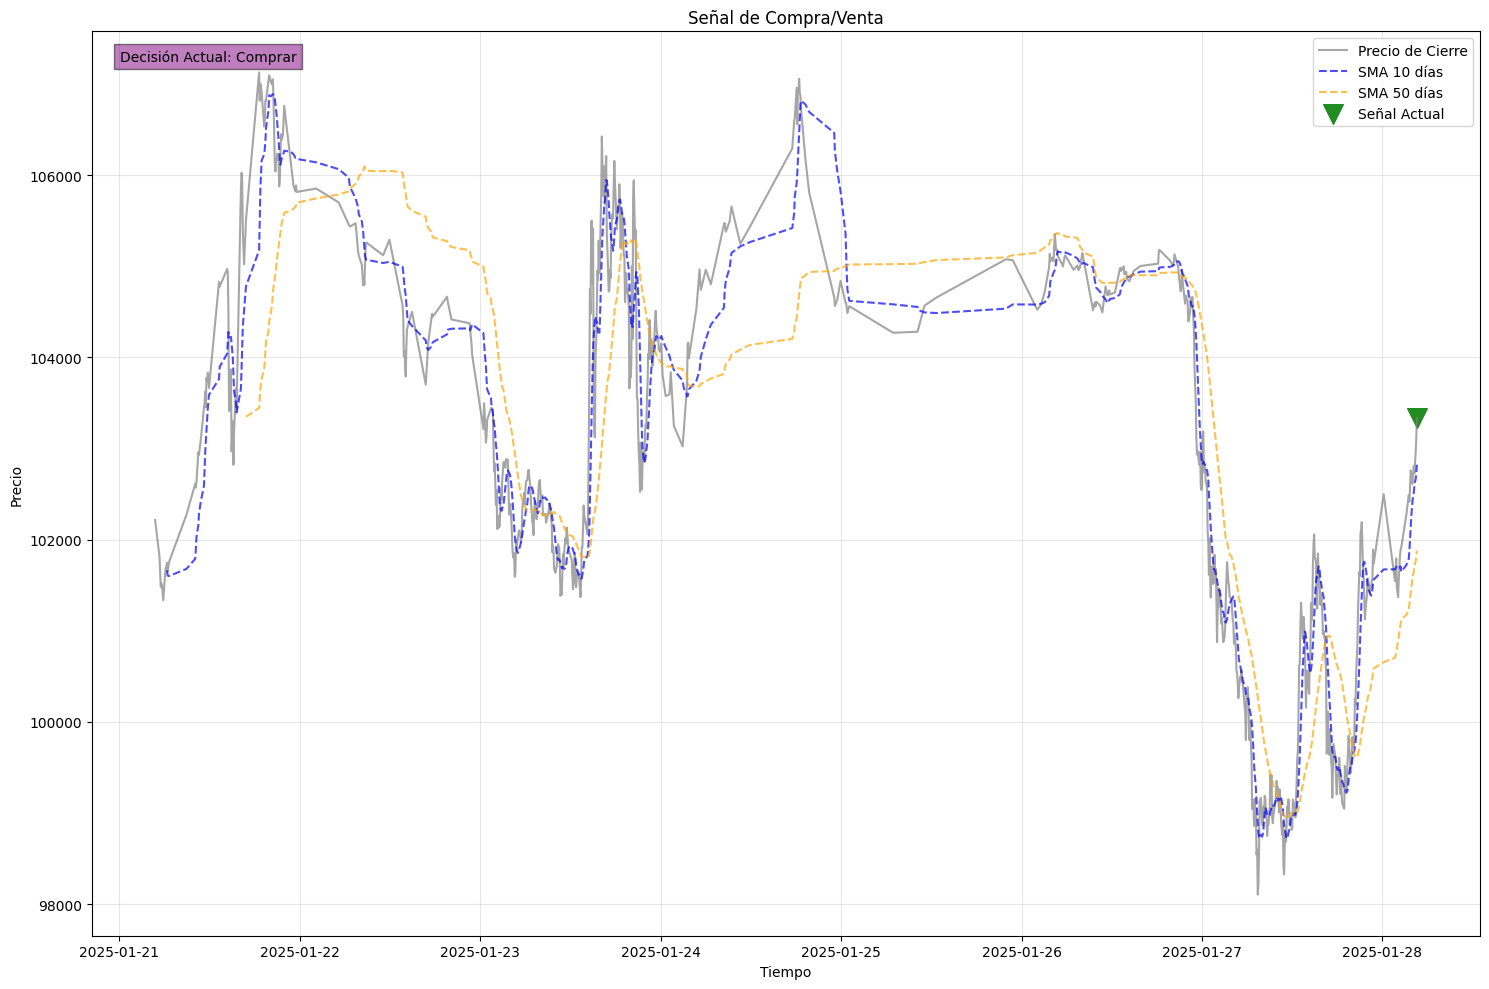

Esperando 5 minutos antes de la siguiente decisión...


In [ ]:
while True:
    print("Iniciando ciclo de análisis...")

    # Paso 1: Descargar los datos y extraer el precio actual
    importar_base_bitcoin()
    extraer_tendencias()

    # Paso 2: Limpiar los datos y calcular las medias móviles
    limpieza_datos()
    calcular_sma()

    # Paso 3: Tomar la decisión de compra/venta
    tomar_decisiones()

    # Paso 4: Graficar las tendencias y señales

    graficar_senal_actual()

    # Esperar 5 minutos antes de la siguiente decisión
    print("Esperando 5 minutos antes de la siguiente decisión...")
    time.sleep(300)